## Building density (Medium)

A buffer radius of 200m is created at each location, and the number of buildings that are between 15 to 20m height is calculated.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submission-building-height-2/Submission_template_UHI2025-v2.csv
/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv


In [2]:
pip install overpy

Note: you may need to restart the kernel to use updated packages.


Number of tall buildings fetched: 16410


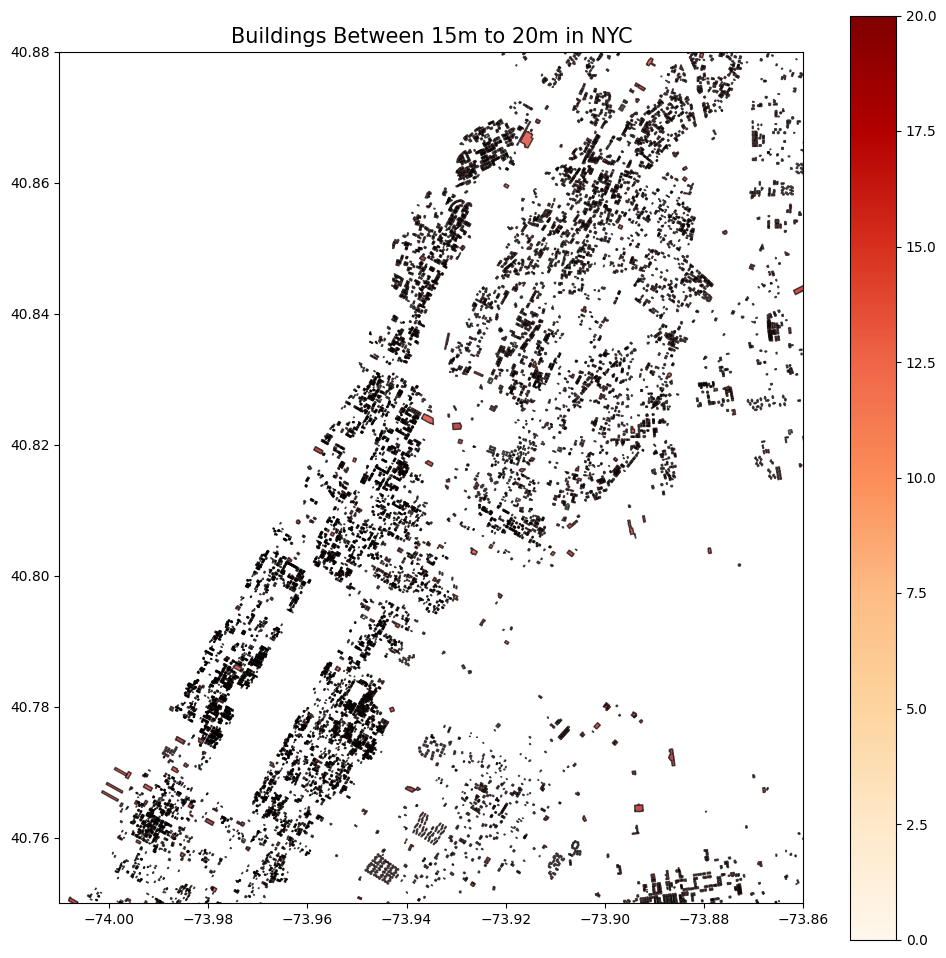

In [3]:
import overpy
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Set up the Overpass API client
api = overpy.Overpass()

# Define the bounding box (Lat, Lon)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

overpass_query = f"""
[out:json][timeout:60];
(
  way["building"]["height"](if:t["height"] >= 15 && t["height"] <= 20)({lower_left[0]},{lower_left[1]},{upper_right[0]},{upper_right[1]});
  relation["building"]["height"](if:t["height"] >= 15 && t["height"] <= 20)({lower_left[0]},{lower_left[1]},{upper_right[0]},{upper_right[1]});
);
out body;
(._;>;);
out skel qt;
"""


try:
    # Fetch data
    result = api.query(overpass_query)
    print(f"Number of tall buildings fetched: {len(result.ways)}")

    geometries, names, heights = [], [], []

    for way in result.ways:
        nodes = [(float(node.lon), float(node.lat)) for node in way.nodes]
        if len(nodes) > 2:  # Ensure valid polygons
            polygon = Polygon(nodes)
            geometries.append(polygon)
            names.append(way.tags.get('name', 'Unnamed'))
            heights.append(float(way.tags.get('height', 0)))

    if geometries:
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame({'name': names, 'height': heights, 'geometry': geometries}, crs="EPSG:4326")

        # Plot buildings
        fig, ax = plt.subplots(figsize=(12, 12))
        gdf.plot(ax=ax, column='height', cmap='OrRd', legend=True, edgecolor='black', alpha=0.7)
        ax.set_xlim(lower_left[1], upper_right[1])
        ax.set_ylim(lower_left[0], upper_right[0])
        ax.set_title("Buildings Between 15m to 20m in NYC", fontsize=15)
        plt.show()

    else:
        print("No tall buildings found.")

except overpy.exception.OverpassTooManyRequests:
    print("Too many requests to Overpass API. Please wait and try again.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


## Add a building count column for training data

In [4]:
train_df = pd.read_csv("/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv")

In [5]:
from shapely.geometry import Point

# Prepare train_df as GeoDataFrame 
gdf_train = gpd.GeoDataFrame(
    train_df,
    geometry=[Point(lon, lat) for lon, lat in zip(train_df['Longitude'], train_df['Latitude'])],
    crs="EPSG:4326"
)
# Reproject train GeoDataFrame to metric CRS
gdf_train = gdf_train.to_crs(epsg=3395)

In [6]:
# Process building data for train_df 
gdf_proj = gdf.to_crs(epsg=3395)
gdf_proj['buffer'] = gdf_proj.geometry.buffer(200)  

# Add 'building_height' to train_df: count how many buffers contain each point
gdf_train['building_height'] = gdf_train.geometry.apply(
    lambda point: sum(gdf_proj['buffer'].contains(point))
)

In [7]:
# Update train_df with the computed building_height 
train_df['building_density_medium'] = gdf_train['building_height']

# Check the results
print(train_df[['Latitude', 'Longitude', 'building_density_medium']].head())

    Latitude  Longitude  building_density_medium
0  40.813107 -73.909167                       14
1  40.813045 -73.909187                       12
2  40.812978 -73.909215                       13
3  40.812908 -73.909242                       14
4  40.812845 -73.909257                       14


In [8]:
train_df["building_density_medium"].describe()

count    11229.000000
mean        20.220590
std         22.737404
min          0.000000
25%          4.000000
50%         13.000000
75%         27.000000
max        159.000000
Name: building_density_medium, dtype: float64

In [9]:
train_df.to_csv('train_df_with_building_density_medium.csv', index=False)

## Repeat for validation data

In [10]:
valid_df = pd.read_csv("/kaggle/input/submission-building-height-2/Submission_template_UHI2025-v2.csv")

In [11]:
# Prepare valid_df as GeoDataFrame
gdf_valid = gpd.GeoDataFrame(
    valid_df,
    geometry=[Point(lon, lat) for lon, lat in zip(valid_df['Longitude'], valid_df['Latitude'])],
    crs="EPSG:4326"
)
# Reproject valid GeoDataFrame to metric CRS
gdf_valid = gdf_valid.to_crs(epsg=3395)

In [12]:
# Process building data for valid_df 
gdf_proj = gdf.to_crs(epsg=3395)
gdf_proj['buffer'] = gdf_proj.geometry.buffer(200)  

# Add 'building_height' to valid_df: count how many buffers contain each point
gdf_valid['building_height'] = gdf_valid.geometry.apply(
    lambda point: sum(gdf_proj['buffer'].contains(point))
)

In [13]:
# Update valid_df with the computed building_height 
valid_df['building_density_medium'] = gdf_valid['building_height']

# Check the results
print(valid_df[['Latitude', 'Longitude', 'building_density_medium']].head())

    Latitude  Longitude  building_density_medium
0  40.788763 -73.971665                       26
1  40.788875 -73.971928                       24
2  40.789080 -73.967080                       29
3  40.789082 -73.972550                       29
4  40.787953 -73.969697                      157


In [14]:
valid_df["building_density_medium"].describe()

count    1040.000000
mean       19.986538
std        22.037107
min         0.000000
25%         4.000000
50%        14.000000
75%        27.000000
max       157.000000
Name: building_density_medium, dtype: float64

In [15]:
valid_df.to_csv('valid_df_with_building_density_medium.csv', index=False)